## Task A: optimize a region

In [118]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import pypsa 
import warnings
warnings.filterwarnings("ignore")

# Import datasets
country = "FIN"
year = 2015

demand = pd.read_csv("electricity_demand.csv", sep=";", index_col=0, parse_dates=True )
demand = demand[country].loc[demand.index.year == year]
demand.index = demand.index.tz_localize(None)

onshore_all = pd.read_csv("onshore_wind_1979-2017.csv", sep=";", index_col=0, parse_dates=True)
onshore_all.index = onshore_all.index.tz_localize(None)
onshore_2015 = onshore_all[country].loc[onshore_all.index.year == year]

solar_all = pd.read_csv("pv_optimal.csv", sep=";", index_col=0, parse_dates=True)
solar_all.index = solar_all.index.tz_localize(None)
solar_2015 = solar_all[country].loc[solar_all.index.year == year]

heat = pd.read_csv("heat_demand.csv", sep=";", index_col=0, parse_dates=True)
heat = heat[country].loc[solar_2015.index.year == year]
heat.index = heat.index.tz_localize(None)

snapshots = demand.index


In [119]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_2030.csv"
costs = pd.read_csv(url, index_col=[0, 1])

# Convert costs to MW
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

# Define default values for missing parameters 
defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}

costs = costs.value.unstack().fillna(defaults)

# Set OCGT cost and emissions to gas values
costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

# Set OCGT cost and emissions to gas values
costs.at["biomass CHP", "CO2 intensity"] = costs.at["solid biomass", "CO2 intensity"]
costs.at["biomass CHP", "fuel"] = costs.at["solid biomass", "fuel"]

# Compute marginal costs
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

# Compute capital costs
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

# Extract relevant costs with nicer names
wind_capital = costs.at["onwind", "capital_cost"] #EUR/MW/a
wind_marginal = costs.at["onwind", "marginal_cost"] #EUR/MWh
solar_capital = costs.at["solar", "capital_cost"] #EUR/MW/a
solar_marginal = costs.at["solar", "marginal_cost"] #EUR/MWh
gas_capital = costs.at["OCGT", "capital_cost"] #EUR/MW/a
gas_marginal = costs.at["OCGT", "marginal_cost"] #EUR/MWh
nuclear_capital = costs.at["nuclear", "capital_cost"] #EUR/MW/a
nuclear_marginal = costs.at["nuclear", "marginal_cost"] #EUR/MWh
pumped_hydro_capital = costs.at["Pumped-Storage-Hydro-store", "capital_cost"] 
pumped_hydro_marginal = costs.at["Pumped-Storage-Hydro-store", "marginal_cost"] #EUR/MWh
biomass_capital = costs.at["biomass CHP", "capital_cost"] #EUR/MW/a
biomass_marginal = costs.at["biomass CHP", "marginal_cost"] #EUR/MWh
coal_capital = costs.at["coal", "capital_cost"] #EUR/MW/a
coal_marginal = costs.at["coal", "marginal_cost"] #EUR/MWh

In [180]:
# Create a PyPSA network
network = pypsa.Network()
network.set_snapshots(snapshots.values)


# Add buses
network.add("Bus", "FIN_el")
#network.add("Bus", "FIN_hydro")

# Add carriers
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "nuclear",
    #"Pumped-Storage-Hydro-store",
    "biomass CHP",
    "coal"
]

colors = ["dodgerblue", "gold", "brown", "blue", "green", "orange", "red"]

for i in range(len(carriers)):
    network.add("Carrier", carriers[i], co2_emissions=costs.at[carriers[i], "CO2 intensity"], color=colors[i])


# Add loads
network.add("Load", "FIN_el_load", bus="FIN_el", p_set=demand.values)


# Add generators
network.add("Generator", "onwind", bus="FIN_el", p_nom_extendable=True, p_max_pu=onshore_2015.values, marginal_cost=wind_marginal, capital_cost=wind_capital, carrier="onwind")
network.add("Generator", "solar", bus="FIN_el", p_nom_extendable=True, p_max_pu=solar_2015.values, marginal_cost=solar_marginal, capital_cost=solar_capital, carrier="solar")
network.add("Generator", "OCGT", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=gas_marginal, efficiency = costs.at["OCGT","efficiency"], capital_cost=gas_capital, carrier="OCGT")
network.add("Generator", "nuclear", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=nuclear_marginal, efficiency = costs.at["nuclear","efficiency"], capital_cost=nuclear_capital, carrier="nuclear")
network.add("Generator", "biomass CHP", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=biomass_marginal, efficiency = costs.at["biomass CHP","efficiency"], capital_cost=biomass_capital, carrier="biomass CHP")
network.add("Generator", "coal", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=coal_marginal, efficiency = costs.at["coal","efficiency"], capital_cost=coal_capital, carrier="coal")


# Add hydro
#network.add("Link", "FIN_hydro", bus0="FIN_hydro", bus1="FIN_el",
 #           p_nom_extendable=True, efficiency=1, p_max_pu=1, p_min_pu=-1, capital_cost=0)

# Add hydro storage
#network.add("StorageUnit", "FIN_pumped_hydro", bus="FIN_hydro", efficiency_store=0.86, efficiency_dispatch=0.86, capital_cost=pumped_hydro_capital, marginal_cost=pumped_hydro_marginal,
 #           p_nom_extendable=True, cyclic_state_of_charge=True) # , inflow = 20


# Optimize
network.optimize(solver_name='gurobi', solver_options={'outputflag': 0})

Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 51.56it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-yb5tn9v6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-yb5tn9v6.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 113886 rows, 52566 columns, 206217 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 206217 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 5.71e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Text(0, 0.5, 'MW')

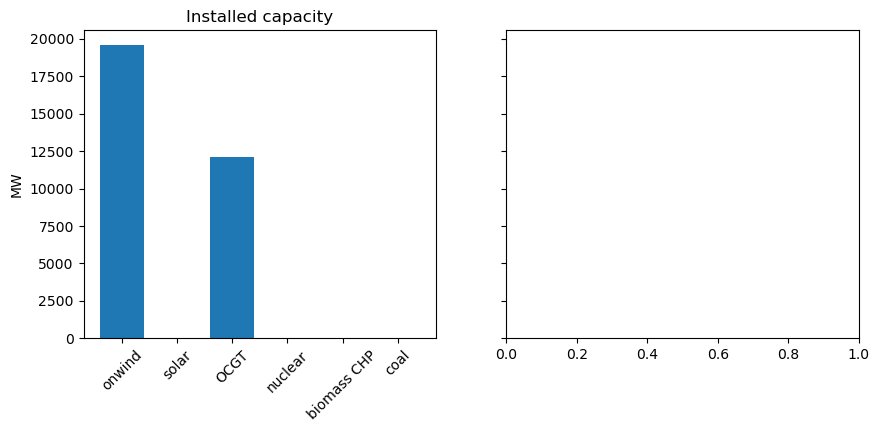

In [181]:
gen_cap = network.generators.p_nom_opt
gen_prod = network.generators_t.p
#hydro_cap = network.storage_units.p_nom_opt
#hydro_prod = network.links_t.p0
#hydroCharge = -hydro_prod.clip(upper=0)
#hydroDischarge = hydro_prod.clip(lower=0)


fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)

ax[0].bar(gen_cap.index, gen_cap.values)
ax[0].set_xticks(ticks = gen_cap.index, labels = gen_cap.index.str.replace("FIN_", "").str.replace("_", " "), rotation=45)
ax[0].set_title("Installed capacity")
ax[0].set_ylabel("MW")


#ax[1].bar(hydro_cap.index, hydro_cap.values)
#ax[1].set_title("Installed capacity (pumped hydro)")
#plt.tight_layout()

In [182]:
#costs.at["OCGT", "CO2 intensity"]
#costs.at["coal", "CO2 intensity"]
#costs.at["biomass CHP", "CO2 intensity"]
#costs.at["nuclear", "CO2 intensity"]
#costs.at["onwind", "CO2 intensity"]

In [183]:
#print("Hydro capacity: ", hydro_cap.values[0])
#print("Hydro power capacity: ", network.links.p_nom_opt.values[0])

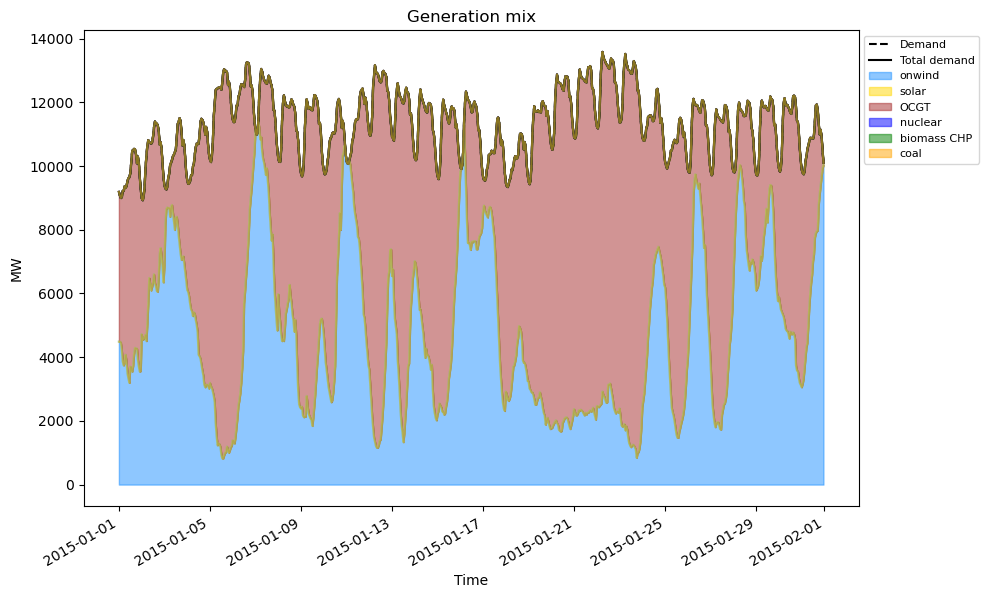

In [184]:
# Plot a week of generation
start_date = "2015-01-01"
end_date = "2015-01-31"

demand_jan = demand.loc[start_date:end_date]
generator_jan = gen_prod.loc[start_date:end_date]
#hydroDischarge_jan = hydroDischarge.loc[start_date:end_date]
#hydroCharge_jan = hydroCharge.loc[start_date:end_date]

#tot_demand_jan = pd.concat([demand_jan, hydroCharge_jan], axis=1).sum(axis=1)
#tot_supply_jan = generator_jan.join(hydroDischarge_jan, how="outer")



fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(demand_jan.index, demand_jan.values, label="Demand", color="black", linestyle="--")
ax.plot(demand_jan.index, demand_jan.values, label="Total demand", color="black")
generator_jan.plot.area(ax=ax, alpha=0.5, stacked=True, color=colors, legend=True)
ax.set_title("Generation mix")
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
plt.show()

In [185]:
# # Plot a week of pumped hydro generation
# fig, ax = plt.subplots(3, 1, figsize=(10,7), sharex=True)
# SOC = network.storage_units_t.state_of_charge#.loc[start_date:end_date]

# #SOC.plot(title="State of charge of pumped hydro in Finland", figsize=(10,5), ax=ax[0], legend=False);
# #hydroCharge.plot(title="Pumped hydro charge in Finland", figsize=(10,5), ax=ax[1], legend=False);
# #hydroDischarge.plot(title="Pumped hydro discharge in Finland", figsize=(10,5), ax=ax[2], legend=False);

# plt.subplots_adjust(hspace=0.5, bottom=0.1, right=0.95, top=0.9)
# plt.show()

Text(0.5, 1.07, 'Electricity mix')

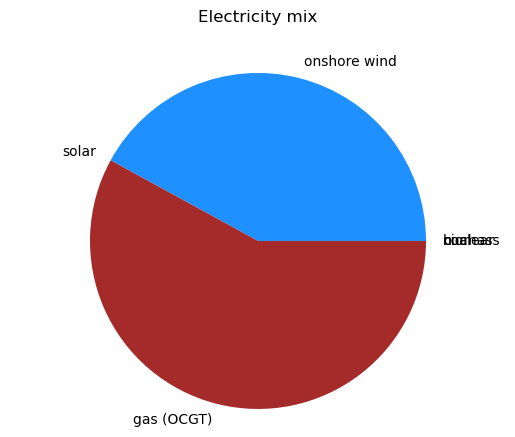

In [186]:
# Plot electricity mix
labels = ['onshore wind',
          'solar',
          'gas (OCGT)',
          "nuclear",
          'biomass',
          'coal',
          #"hydro"
          ]
sizes = [network.generators_t.p['onwind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum(),
         network.generators_t.p['nuclear'].sum(),
         network.generators_t.p['biomass CHP'].sum(),
         network.generators_t.p['coal'].sum(),
         #hydroDischarge.sum().values[0]
         ]

# colors=['blue', 'orange', 'brown', 'green']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [187]:
gen_prod.columns

Index(['onwind', 'solar', 'OCGT', 'nuclear', 'biomass CHP', 'coal'], dtype='object', name='Generator')

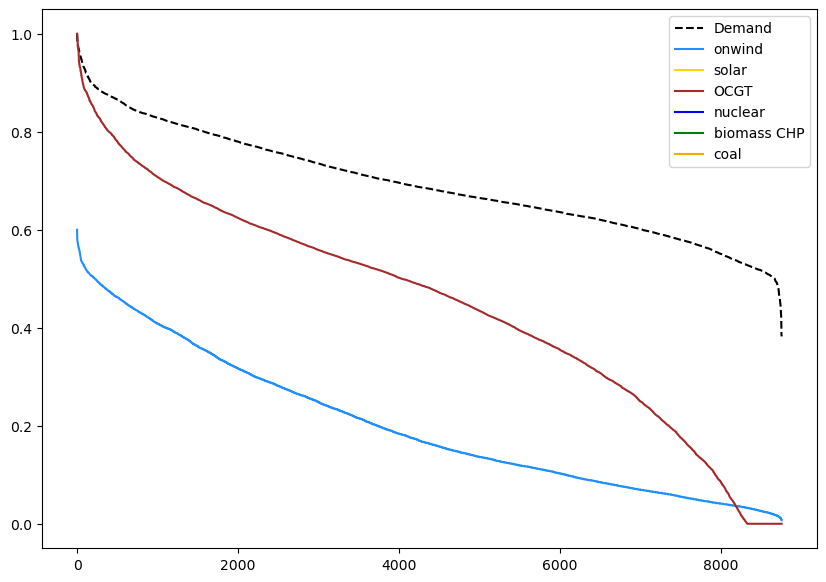

In [188]:
# Plot duration curves of generation and demand
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot((demand/max(demand)).sort_values(ascending=False).reset_index(drop=True), label="Demand", color="black", linestyle="--")

for i, col in enumerate(gen_prod.columns):
    ax.plot((gen_prod[col]/gen_cap[col]).sort_values(ascending=False).reset_index(drop=True), label=col, color=colors[i])

plt.legend()
plt.show()

## B: CO2 limits

In [189]:
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=11000000, #11.9MtCO2
    type="primary_energy",
)

sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}
co2_price = pd.Series()
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

co2Limits = [11.9, 6, 3, 1, 0]
for co2 in co2Limits:
    network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})
    sensitivity_cost[co2] = system_cost(network)
    sensitivity_capacity[co2] = network.generators.p_nom_opt
    sensitivity_production[co2] = network.generators_t.p.sum(axis=0)
    co2_price[co2] = -network.global_constraints.mu['CO2Limit']

Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 49.06it/s]
INFO:linopy.io: Writing time: 0.31s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-i7jo1_gw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-i7jo1_gw.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 113887 rows, 52566 columns, 232497 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 232497 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 6.43e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 50.80it/s]
INFO:linopy.io: Writing time: 0.31s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-_ioq60j8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-_ioq60j8.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 113887 rows, 52566 columns, 232497 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 232497 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 7.35e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 49.87it/s]
INFO:linopy.io: Writing time: 0.32s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-ho61vk6l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-ho61vk6l.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 113887 rows, 52566 columns, 232497 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 232497 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 7.97e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 50.92it/s]
INFO:linopy.io: Writing time: 0.31s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-mefweef0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-mefweef0.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 113887 rows, 52566 columns, 232497 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 232497 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 8.78e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['FIN_el'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 50.59it/s]
INFO:linopy.io: Writing time: 0.31s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-shgormas.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-shgormas.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 113887 rows, 52566 columns, 232497 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 232497 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 1.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


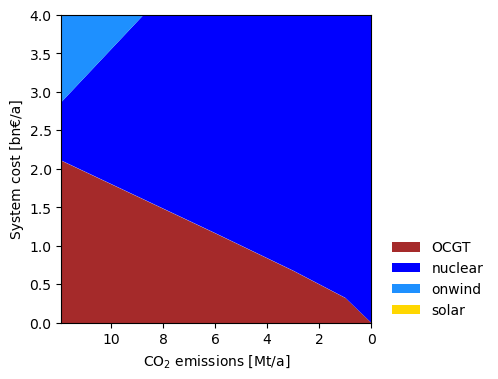

In [190]:
sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T
sens_prod = pd.DataFrame(sensitivity_production).T.div(1e3)  # GWh/a

sens_cost.plot.area(
    stacked=True,
    linewidth=0,
    color=sens_cost.columns.map(network.carriers.color),
    figsize=(4, 4),
    xlim=(min(co2Limits), max(co2Limits)),
    xlabel=r"CO$_2$ emissions [Mt/a]",
    ylabel="System cost [bn€/a]",
    ylim=(0, 4),
)
plt.legend(frameon=False, loc=(1.05, 0))
plt.gca().invert_xaxis()

## C: new weather

In [191]:
network.generators.loc["onwind", "p_max_pu"]

1.0

In [192]:
network.generators_t["p_max_pu"].onwind = 


SyntaxError: invalid syntax (2113383915.py, line 1)

In [ ]:
weather_years = [2001, 2010, 2015, 2017]

sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}

for year in weather_years:
    onshore = onshore_all[country].loc[onshore_all.index.year == year]
    solar = solar_all[country].loc[solar_all.index.year == year]

    network.generators_t["p_max_pu"] = network.generators_t["p_max_pu"].assign(
    onwind=onshore.values,
    solar=solar.values
    )
    print(network.generators_t.p_max_pu["onwind"].head())
    print(onshore.head())  # Should match!
    network.snapshots = solar.index
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})
    sensitivity_cost[year] = system_cost(network)
    sensitivity_capacity[year] = network.generators.p_nom_opt
    sensitivity_production[year] = network.generators_t.p

sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T
#sens_prod = pd.DataFrame(sensitivity_production).T.div(1e3)  # GWh/a
    

Index(['FIN_el', 'FIN_hydro'], dtype='object', name='Bus')


snapshot
2015-01-01 00:00:00    0.024
2015-01-01 01:00:00    0.026
2015-01-01 02:00:00    0.028
2015-01-01 03:00:00    0.030
2015-01-01 04:00:00    0.031
Name: onwind, dtype: float64
utc_time
2001-01-01 00:00:00    0.024
2001-01-01 01:00:00    0.026
2001-01-01 02:00:00    0.028
2001-01-01 03:00:00    0.030
2001-01-01 04:00:00    0.031
Name: FIN, dtype: float64


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 50.13it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-jyiufb_u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-jyiufb_u.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 113886 rows, 52566 columns, 210246 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 210246 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 0.00e+00
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['FIN_el', 'FIN_hydro'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.


snapshot
2001-01-01 00:00:00    0.276
2001-01-01 01:00:00    0.268
2001-01-01 02:00:00    0.264
2001-01-01 03:00:00    0.261
2001-01-01 04:00:00    0.259
Name: onwind, dtype: float64
utc_time
2010-01-01 00:00:00    0.276
2010-01-01 01:00:00    0.268
2010-01-01 02:00:00    0.264
2010-01-01 03:00:00    0.261
2010-01-01 04:00:00    0.259
Name: FIN, dtype: float64


Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 49.47it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-97980rhu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-97980rhu.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 113886 rows, 52566 columns, 210246 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 210246 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 0.00e+00
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['FIN_el', 'FIN_hydro'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0


snapshot
2010-01-01 00:00:00    0.229
2010-01-01 01:00:00    0.229
2010-01-01 02:00:00    0.228
2010-01-01 03:00:00    0.216
2010-01-01 04:00:00    0.197
Name: onwind, dtype: float64
utc_time
2015-01-01 00:00:00    0.229
2015-01-01 01:00:00    0.229
2015-01-01 02:00:00    0.228
2015-01-01 03:00:00    0.216
2015-01-01 04:00:00    0.197
Name: FIN, dtype: float64


INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 48.14it/s]
INFO:linopy.io: Writing time: 0.3s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-jd49papb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-jd49papb.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 113886 rows, 52566 columns, 210246 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 210246 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 0.00e+00
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['FIN_el', 'FIN_hydro'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0
INFO:linopy.io:Writing objective.


snapshot
2015-01-01 00:00:00    0.201
2015-01-01 01:00:00    0.173
2015-01-01 02:00:00    0.140
2015-01-01 03:00:00    0.119
2015-01-01 04:00:00    0.101
Name: onwind, dtype: float64
utc_time
2017-01-01 00:00:00    0.201
2017-01-01 01:00:00    0.173
2017-01-01 02:00:00    0.140
2017-01-01 03:00:00    0.119
2017-01-01 04:00:00    0.101
Name: FIN, dtype: float64


Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 48.41it/s]
INFO:linopy.io: Writing time: 0.3s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-7ot1ac0w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/77/s1_g3zmn2lb_1hrf3l7z5cjc0000gn/T/linopy-problem-7ot1ac0w.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 113886 rows, 52566 columns, 210246 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 210246 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 0.00e+00
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [193]:
sens_cap

Generator,onwind,solar,OCGT,nuclear,biomass CHP,coal
11.9,1016.129032,0.0,0.0,13432.596774,0.0,0.0
6.0,1016.129032,0.0,0.0,13432.596774,0.0,0.0
3.0,1016.129032,0.0,0.0,13432.596774,0.0,0.0
1.0,1016.129032,0.0,0.0,13432.596774,0.0,0.0
0.0,1016.129032,0.0,0.0,13432.596774,0.0,0.0


KeyError: 2001

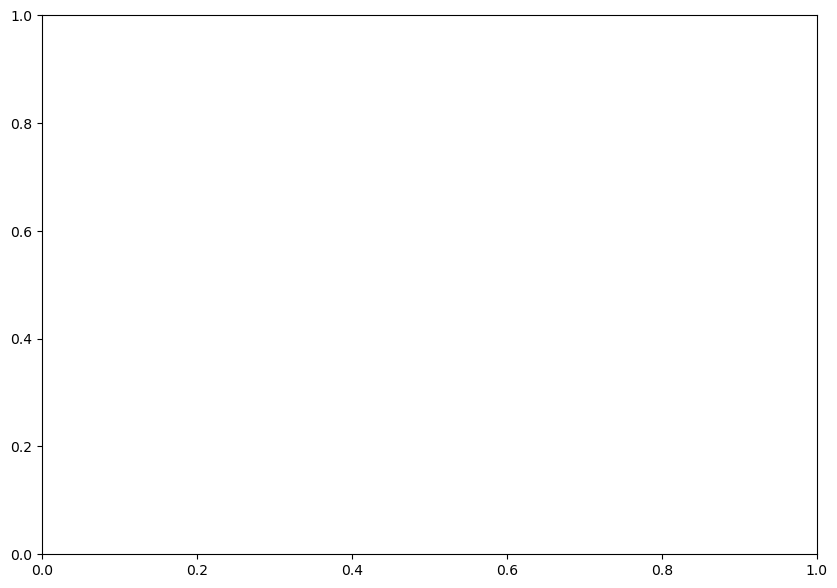

In [194]:

# Plot duration curves sensitivity

fig , ax = plt.subplots(1, 1, figsize=(10,7))
for year in weather_years:
    ax.plot((sensitivity_production[year]["onwind"]/sens_cap.loc[year, "onwind"]).sort_values(ascending=False).reset_index(drop=True), label=year)
plt.legend()
plt.show()

fig , ax = plt.subplots(1, 1, figsize=(10,7))
for year in weather_years:
    ax.plot((sensitivity_production[year]["nuclear"]/sens_cap.loc[year, "nuclear"]).sort_values(ascending=False).reset_index(drop=True), label=year)
plt.legend()
plt.show()